In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

Map:   0%|          | 0/2433 [00:00<?, ? examples/s]

Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.690800,0.675793,0.742704
2,0.609800,0.573943,0.775175
3,0.487500,0.562349,0.783395


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



📊 Weighted Metrics for XLM-RoBERTa-Base
-------------------------------------------
Accuracy          : 0.7757
Weighted Precision: 0.7716
Weighted Recall   : 0.7757
Weighted F1-score : 0.7736


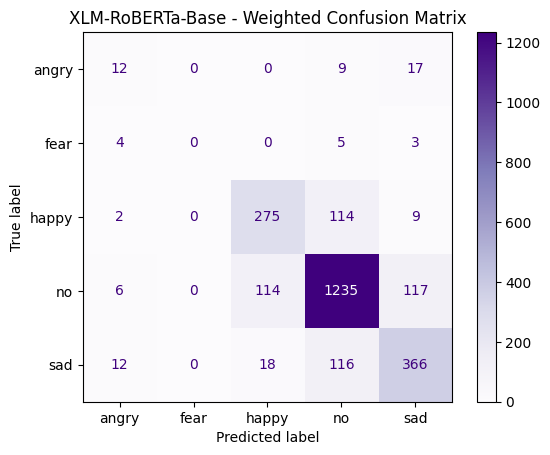


Detailed Classification Report:
              precision    recall  f1-score   support

       angry      0.333     0.316     0.324        38
        fear      0.000     0.000     0.000        12
       happy      0.676     0.688     0.682       400
          no      0.835     0.839     0.837      1472
         sad      0.715     0.715     0.715       512

    accuracy                          0.776      2434
   macro avg      0.512     0.511     0.512      2434
weighted avg      0.772     0.776     0.774      2434


✅ All results saved to xlm_base_weighted_results.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
# =============================
# NLP Project: XLM-RoBERTa-Base Emotion Classification (Weighted Metrics)
# =============================

!pip install -q transformers datasets scikit-learn torch
!pip install protobuf==3.20.3 --quiet

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pickle
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Dataset
# -----------------------------
train_df = pd.read_csv("/kaggle/input/nlpdataset/train.csv")[['Sentence', 'Emotion']]
val_df = pd.read_csv("/kaggle/input/nlpdataset/val.csv")[['Sentence', 'Emotion']]
test_df = pd.read_csv("/kaggle/input/nlpdataset/test.csv")[['Sentence', 'Emotion']]

# Encode labels
le = LabelEncoder()
train_df['Emotion'] = le.fit_transform(train_df['Emotion'])
val_df['Emotion'] = le.transform(val_df['Emotion'])
test_df['Emotion'] = le.transform(test_df['Emotion'])
num_labels = len(le.classes_)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# -----------------------------
# 2. Tokenization
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["Sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename label column
train_dataset = train_dataset.rename_column("Emotion", "labels")
val_dataset = val_dataset.rename_column("Emotion", "labels")
test_dataset = test_dataset.rename_column("Emotion", "labels")

# Set PyTorch format
columns = ["input_ids", "attention_mask", "labels"]
train_dataset.set_format("torch", columns=columns)
val_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)

# -----------------------------
# 3. Model
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    num_labels=num_labels
)

# -----------------------------
# 4. Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./xlm_base_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,   # base model is lighter → larger batch
    per_device_eval_batch_size=16,
    learning_rate=3e-5,               # slightly higher LR works well for base
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=False
)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# -----------------------------
# 5. Trainer
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# -----------------------------
# 6. Train
# -----------------------------
trainer.train()

# -----------------------------
# 7. Predict on Test Set
# -----------------------------
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=-1)
y_true = test_df["Emotion"].values
classes = le.classes_

# -----------------------------
# 8. Weighted Metrics
# -----------------------------
weighted_precision = precision_score(y_true, y_pred, average="weighted")
weighted_recall = recall_score(y_true, y_pred, average="weighted")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print("\n📊 Weighted Metrics for XLM-RoBERTa-Base")
print("-------------------------------------------")
print(f"Accuracy          : {accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall   : {weighted_recall:.4f}")
print(f"Weighted F1-score : {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Purples", values_format="d")
plt.title("XLM-RoBERTa-Base - Weighted Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=classes, digits=3)
print("\nDetailed Classification Report:")
print(report)

# -----------------------------
# 9. Save Results to Pickle
# -----------------------------
results = {
    "model_name": "xlm-roberta-base",
    "label_encoder": le,
    "preds": y_pred,
    "confusion_matrix": cm,
    "classification_report": report,
    "accuracy": accuracy,
    "weighted_precision": weighted_precision,
    "weighted_recall": weighted_recall,
    "weighted_f1": weighted_f1
}

with open("xlm_base_weighted_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\n✅ All results saved to xlm_base_weighted_results.pkl")
